# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances
to check and fixes them if they had been flipped.

In [3]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts

from scripts import cleaning


Run 1, seed: 1
train instances: 26215
test instances: 6554
sum before: 24711
ones flipped: 9871
zeros flipped: 615
sum after: 15455
num noisy labels: 10486

Before noise:
train set acc: 0.946176
train log loss: 0.16173
train auroc: 0.873
test set acc: 0.941562
test log loss: 0.18010
test auroc: 0.820

After noise:
train set acc: 0.619111
train log loss: 0.64896
train auroc: 0.657
test set acc: 0.883583
test log loss: 0.55343
test auroc: 0.547

Using predicted labels:
incorrectly predicted corrupted labels: 8773
total number of incorrectly predicted labels: 9985
ordering by random...


100%|██████████| 10/10 [00:08<00:00,  1.30it/s]

time: 8.478069s
ordering by tree loss...



100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

time: 8.866930s
ordering by our method...


C=0.01: 34.375s; corr=0.507
C=0.1: 26.765s; corr=0.663
C=1.0: 39.130s; corr=0.780
C=10.0: 23.652s; corr=0.719
C=100.0: 22.341s; corr=0.666
C: 1.0


100%|██████████| 10/10 [00:12<00:00,  1.34s/it]

time: 202.920677s
plotting...


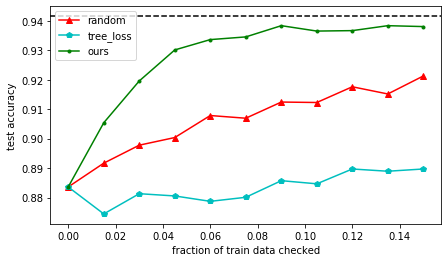

In [2]:
args = cleaning.Args()
args.dataset='amazon'              # Dataset to use
args.tree_type='cb'                # cb (Catboost), lgb, or xgb
args.tree_kernel='leaf_output'     # Tree kernel
args.kernel_model='lr'             # Kernel model type
args.kernel_model_kernel='linear'  # Kernel model kernel
args.check_pct=0.15                # Fraction of samples to check/fix
args.data_dir='../../data/'        # Dataset directory
cleaning.main(args)